# Atlanta Zipcode Investment Analysis

## Imports

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LassoLarsCV
from datetime import date

## Data

**Data Source:** Zillow.com

We're analyzing summarized house values data from different zip codes across the US from April 1996 to April 2018. The data points are monthly.

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


For our analysis, we will be looking at the 12 zipcodes in Atlanta, GA. The first thing we'll do is drop the other zipcodes and create our base dataframe with just the 12 zipcodes we will be looking at.

In [3]:
ga_df = df[df['State'] == 'GA']
atl_df = ga_df[df['Metro'] == 'Atlanta']
atl_df = atl_df[df['City'] == 'Atlanta']
atl_df.reset_index(inplace=True)
atl_df.head()

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,index,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
1,1097,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0,261700.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
2,1223,71043,30324,Atlanta,GA,Atlanta,Fulton,1224,189400.0,190800.0,...,506500,509600,515100,519600,523900,528500,532600,537900,543700,545700
3,1758,71036,30316,Atlanta,GA,Atlanta,Fulton,1759,62300.0,62300.0,...,240900,244200,247900,251700,255300,258800,261600,264300,268700,272500
4,1787,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0,299000.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200


Next, we take the dataframe and drop all the unneccessary columns to set up our analysis for time series. We'll create a list with the zipcodes and a pandas series for the house values and use the dates as the index values. We'll set these formally to DateTimeIndex to make our time series analysis easier.

In [4]:
zipcodes = []
zipcode_dfs = []
for idx,zipcode in zip(atl_df.index, atl_df['RegionName']):
    zipcodes.append(zipcode)
    zipcode_df = atl_df.drop(['index', 'RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
    zipcode_dfs.append(zipcode_df.iloc[idx])

In [5]:
for zipcode_df in zipcode_dfs:
    zipcode_df.index = pd.DatetimeIndex(zipcode_df.index, freq='infer')
for zipcode, df in zip(zipcodes, zipcode_dfs):
    df.name = str(zipcode)

## Zipcode House Value Visualization
Next, we'll visualize on a line graph the zipcodes we are analyzing. The values trend mostly upward except for starting in 2008. This is due to the 2008 Economic Recession that greatly impacted the housing market in the United States.

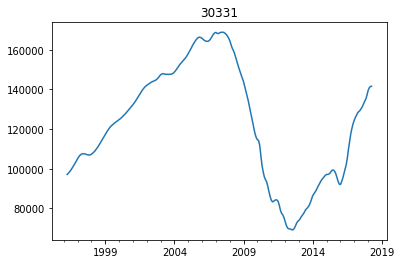

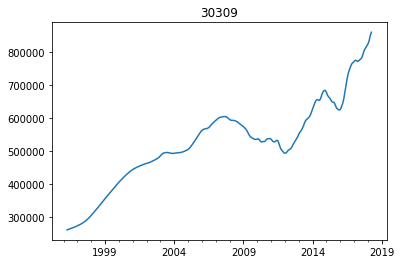

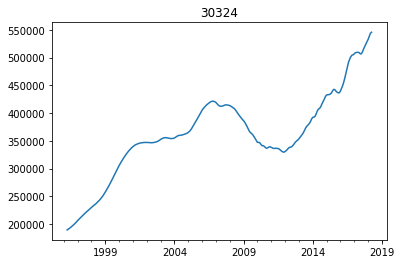

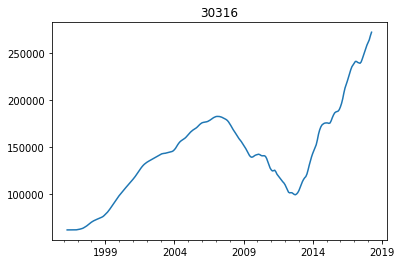

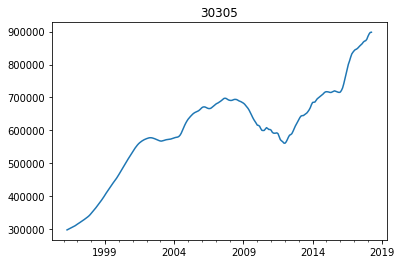

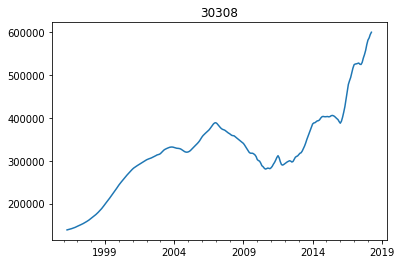

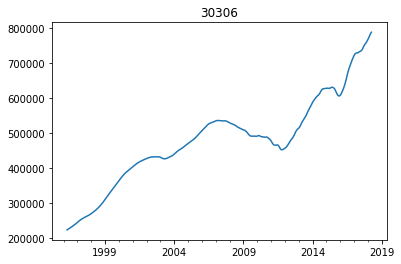

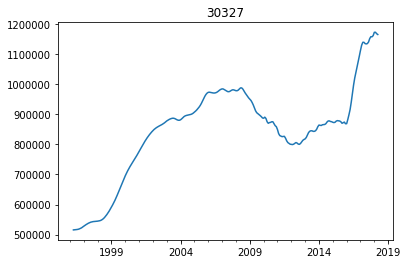

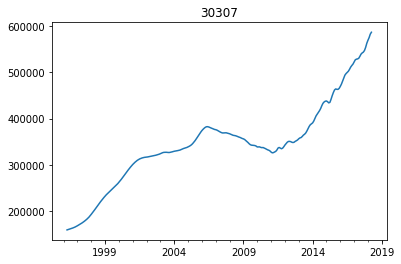

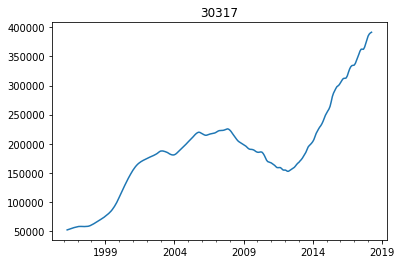

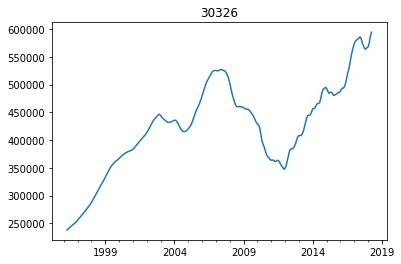

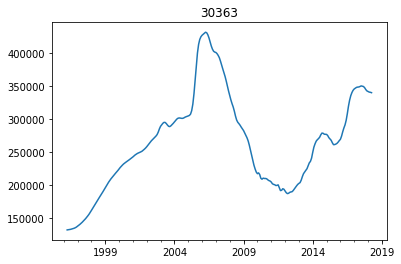

In [6]:
for df_,name in zip(zipcode_dfs,zipcodes):
    df_.plot()
    plt.title(name)
    plt.show()

Next, we'll take a look at breaking down the trend, seasonality, and residual noise for each of the zipcodes. We can see there is a negligible seasonality component and some residual noise, but the plot's confirm the general upward trend in housing prices.

Zipcode: 30331


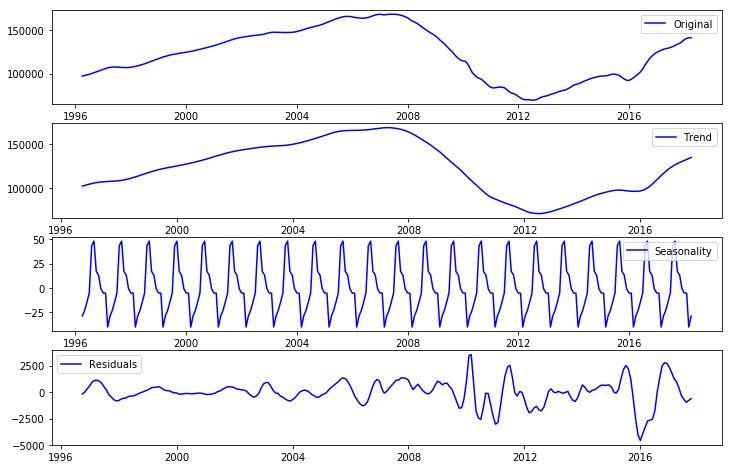

Zipcode: 30309


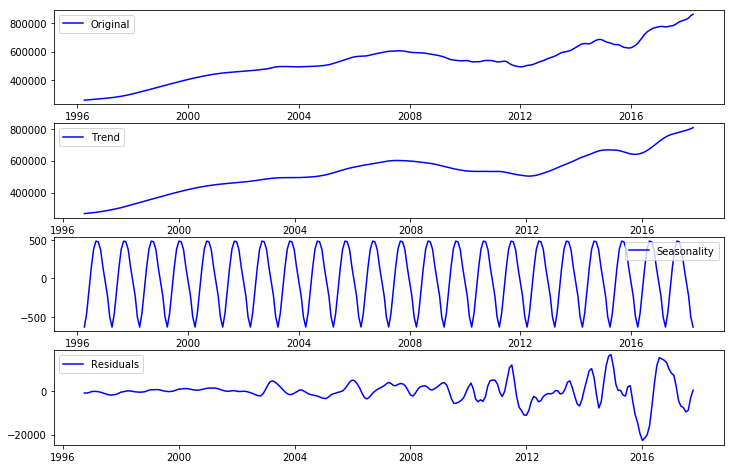

Zipcode: 30324


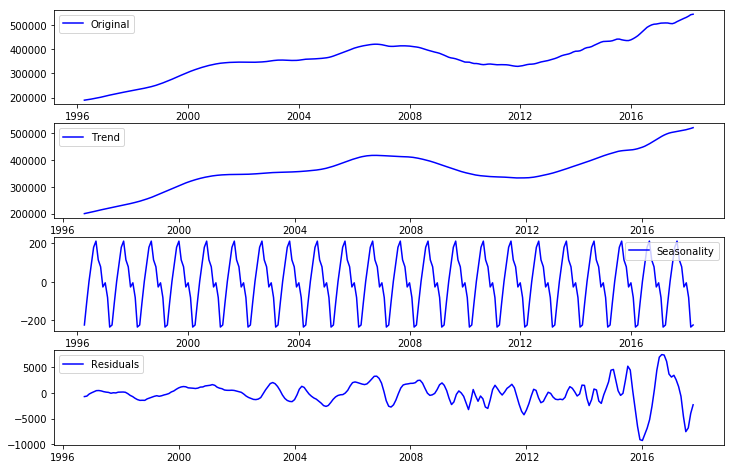

Zipcode: 30316


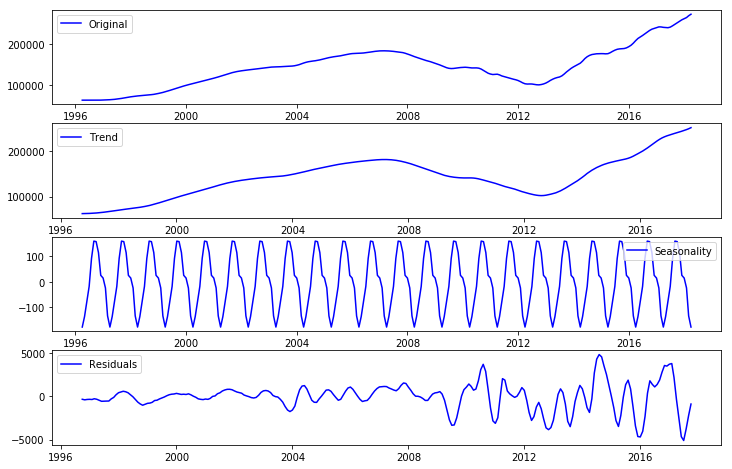

Zipcode: 30305


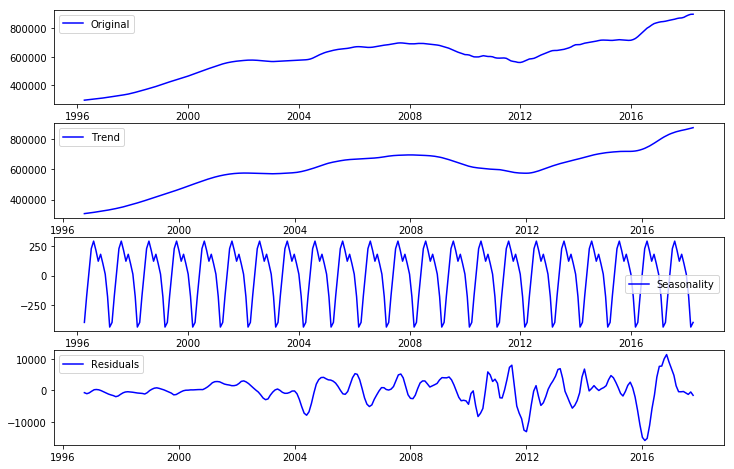

Zipcode: 30308


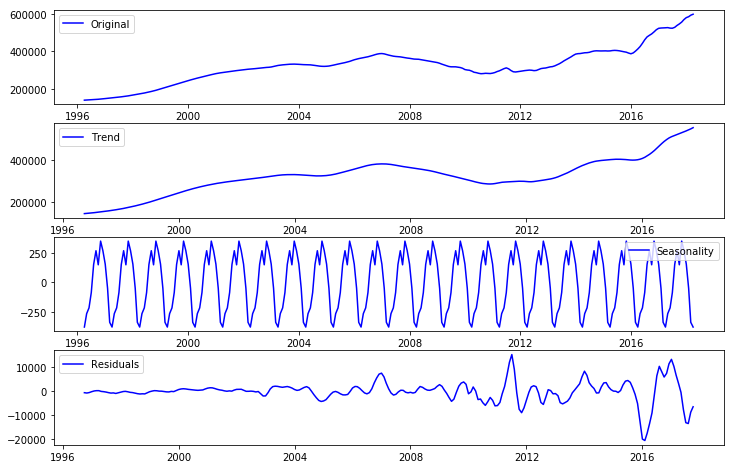

Zipcode: 30306


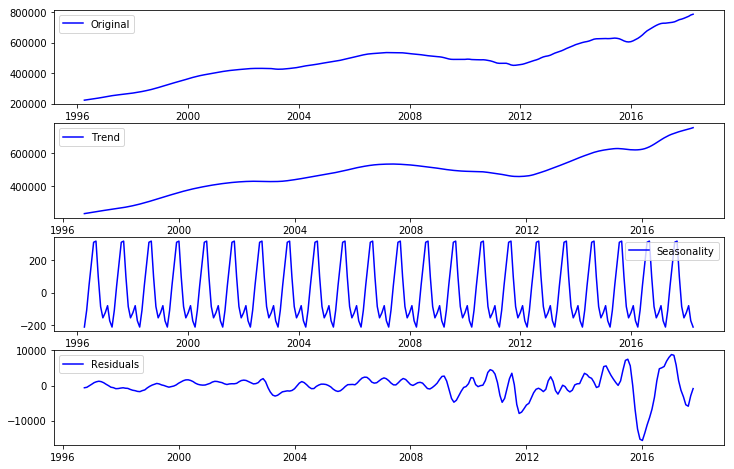

Zipcode: 30327


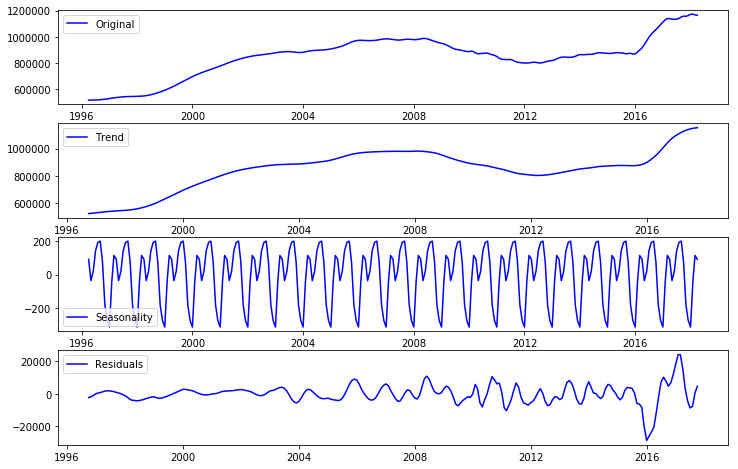

Zipcode: 30307


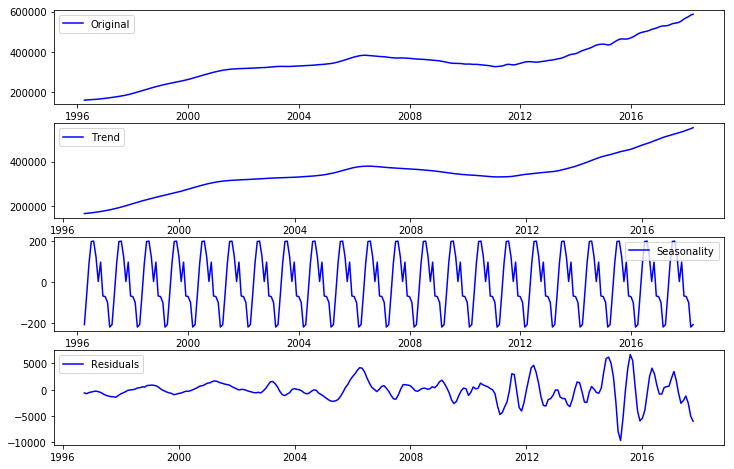

Zipcode: 30317


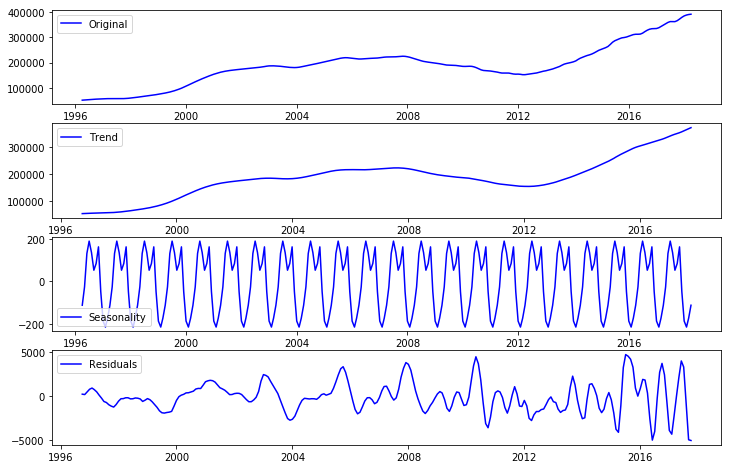

Zipcode: 30326


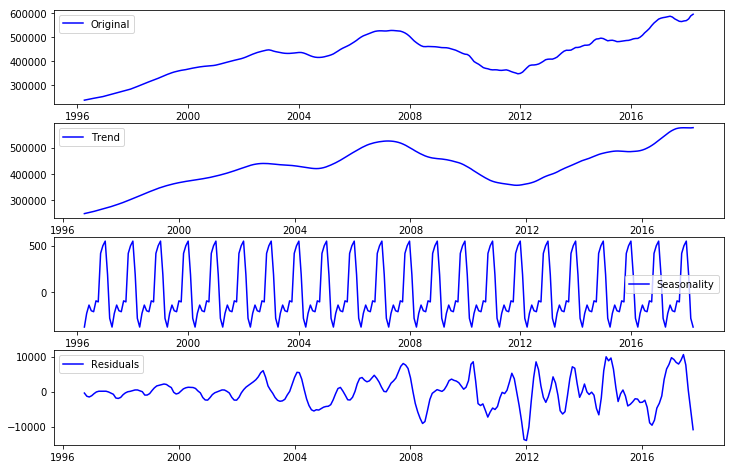

Zipcode: 30363


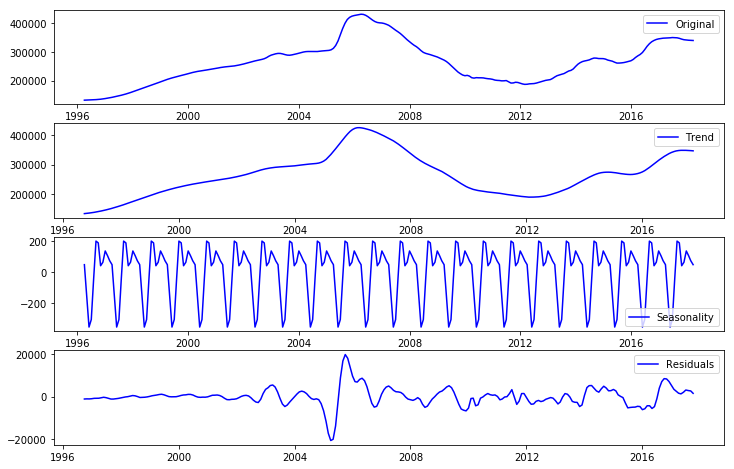

In [7]:
# Import and apply seasonal_decompose()
for df in zipcode_dfs:
    decomposition = seasonal_decompose(df)
# Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
# Plot gathered statistics
    print('Zipcode:', df.name)
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.show()

## ARIMA
The first approach we will take for fitting a time series to our model is ARIMA. This approach makes the most sense to try because the data is not stationary. Therefore, using the ARIMA approach will help us account for that. We won't use seasonal ARIMA because the seasonal component of the housing values was negligible.

ARIMA is combination of three compontents of a time series model: the autoregressive model (AR), the integrated compontent (I), and the moving average component (MA). The AR model predicts values using prvious values from the same time series. The MA component is the weighted sum of today's and yesterday's noise. The I component helps account for the trend component of a time series so the data doesn't need to be stationary.

We first need to set up a set of training data for our zipcodes so we can have data to fit using our different approaches while also having some data to test and get MSE with. For our training data, we will use everything before 2017 and use 2017 to test our model accuracies with.

In [8]:
zipcode_dfs_train = []
for df in zipcode_dfs:
    zipcode_dfs_train.append(df[df.index.year < 2017])

Next, we're going to visualize the data for the different zipcodes using an ARIMA model with an order of one for each of the p, d, and q components.

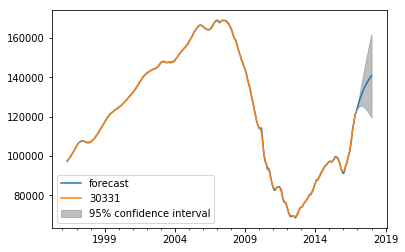

AIC: 3649.8715865894924
BIC: 3663.9253015741524
ARIMA Model not able to be fit
ARIMA Model not able to be fit


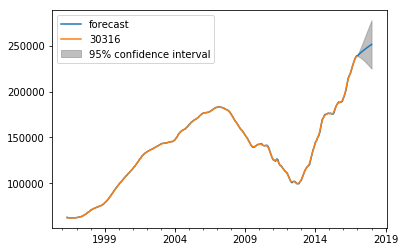

AIC: 3704.3929407021756
BIC: 3718.4466556868356


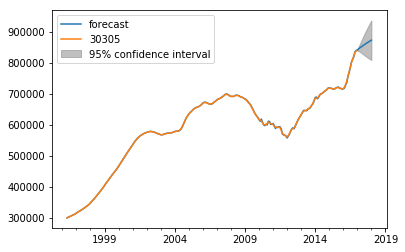

AIC: 4278.310320036457
BIC: 4292.364035021116


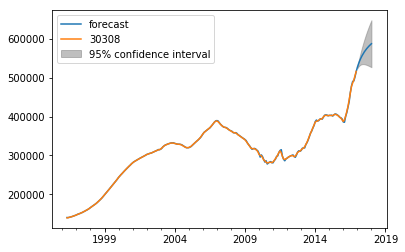

AIC: 4272.0619436701945
BIC: 4286.115658654854


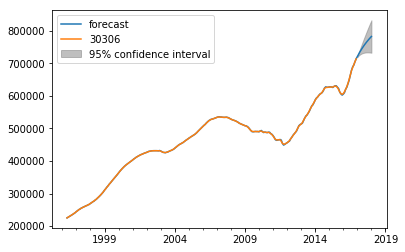

AIC: 4015.2545388386184
BIC: 4029.3082538232784


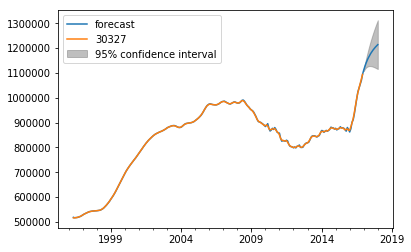

AIC: 4464.35736579157
BIC: 4478.41108077623


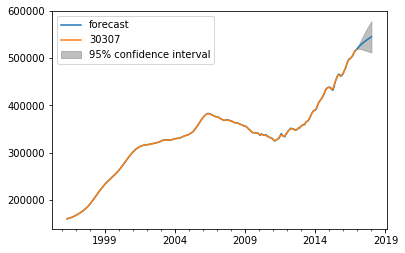

AIC: 3951.7751439406507
BIC: 3965.8288589253107


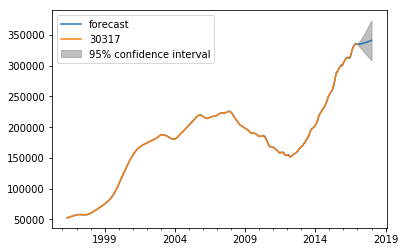

AIC: 3845.654212820212
BIC: 3859.707927804872


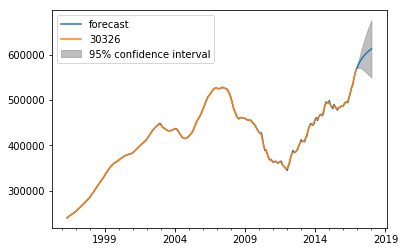

AIC: 4345.843609608458
BIC: 4359.897324593117


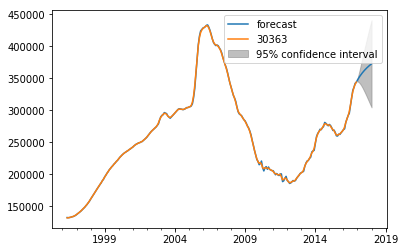

AIC: 4206.783648106626
BIC: 4220.837363091286


In [9]:
for zipcode in zipcode_dfs_train:
    try:
        arima_model = ARIMA(zipcode, order=(1,1,1)).fit()
    except:
        print("ARIMA Model not able to be fit")
        continue
    arima_model.plot_predict(1, len(zipcode)+12); plt.show()
    print('AIC:', arima_model.aic)
    print('BIC:', arima_model.bic)

While for most of the zipcodes the ARIMA models fit the existing data pretty well, some of the zipcodes could not be fit due to the orders used for the ARIMA. Some of the ARIMA models also have really wide prediction ranges for the predicted 12 months of data. In order to find the optimal ARIMA order parameters for each of the zipcodes, we'll use auto ARIMA to try different values of orders for the zipcodes and find which is the best fit using AIC and BIC.

In [10]:
fit_arima_models = []
for df in zipcode_dfs_train:
    print('Zipcode:', df.name)
    model = auto_arima(df, trace=True, error_action='ignore', suppress_warnings=True, seasonal=False)
    fit_arima_models.append(model)

Zipcode: 30331
Fit ARIMA: order=(2, 2, 2); AIC=3623.976, BIC=3645.032, Fit time=0.543 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3717.839, BIC=3724.858, Fit time=0.011 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3669.101, BIC=3679.629, Fit time=0.086 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3642.362, BIC=3652.891, Fit time=0.066 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds


/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(3, 2, 2); AIC=3625.973, BIC=3650.538, Fit time=0.860 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3624.128, BIC=3641.675, Fit time=0.350 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 1); AIC=3642.579, BIC=3656.617, Fit time=0.215 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3605.913, BIC=3633.988, Fit time=0.936 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3604.315, BIC=3635.900, Fit time=1.783 seconds
Fit ARIMA: order=(4, 2, 2); AIC=3617.055, BIC=3645.131, Fit time=1.207 seconds
Fit ARIMA: order=(4, 2, 4); AIC=nan, BIC=nan, Fit time=1.175 seconds
Fit ARIMA: order=(5, 2, 4); AIC=3602.691, BIC=3641.294, Fit time=2.311 seconds
Fit ARIMA: order=(5, 2, 3); AIC=3602.195, BIC=3637.289, Fit time=1.386 seconds
Fit ARIMA: order=(5, 2, 2); AIC=3600.762, BIC=3632.346, Fit time=0.969 seconds
Fit ARIMA: order=(4, 2, 1); AIC=3624.089, BIC=3648.655, Fit time=0.472 seconds
Fit ARIMA: order=(5, 2, 1); AIC=3614.100, BIC=3642.175, Fit time=0.736 sec

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(1, 1, 2); AIC=4250.439, BIC=4268.006, Fit time=0.604 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4233.059, BIC=4257.653, Fit time=0.450 seconds
Fit ARIMA: order=(3, 1, 1); AIC=4271.070, BIC=4292.150, Fit time=0.320 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4232.144, BIC=4260.251, Fit time=1.063 seconds
Fit ARIMA: order=(4, 1, 4); AIC=4235.757, BIC=4270.891, Fit time=2.465 seconds
Fit ARIMA: order=(2, 1, 3); AIC=4238.734, BIC=4263.328, Fit time=0.725 seconds
Fit ARIMA: order=(4, 1, 3); AIC=4233.953, BIC=4265.573, Fit time=0.627 seconds
Fit ARIMA: order=(3, 1, 4); AIC=4228.536, BIC=4260.157, Fit time=1.519 seconds
Fit ARIMA: order=(4, 1, 5); AIC=4227.041, BIC=4265.689, Fit time=2.751 seconds
Fit ARIMA: order=(3, 1, 5); AIC=4225.185, BIC=4260.319, Fit time=2.074 seconds
Fit ARIMA: order=(2, 1, 4); AIC=4239.825, BIC=4267.932, Fit time=0.943 seconds
Fit ARIMA: order=(2, 1, 5); AIC=4232.837, BIC=4264.458, Fit time=1.241 seconds
Total fit time: 15.320 seconds
Zipcode: 30324
Fit AR

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(0, 2, 1); AIC=3918.235, BIC=3928.763, Fit time=0.202 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 2); AIC=3874.814, BIC=3899.380, Fit time=0.690 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3889.558, BIC=3907.105, Fit time=0.335 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3872.827, BIC=3897.392, Fit time=0.611 seconds
Fit ARIMA: order=(3, 2, 4); AIC=3869.937, BIC=3901.521, Fit time=1.547 seconds
Fit ARIMA: order=(2, 2, 4); AIC=3870.401, BIC=3898.477, Fit time=1.027 seconds
Fit ARIMA: order=(4, 2, 4); AIC=3869.959, BIC=3905.053, Fit time=1.815 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3867.857, BIC=3895.932, Fit time=1.229 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3869.857, BIC=3901.441, Fit time=0.924 seconds
Total fit time: 9.129 seconds
Zipcode: 30316
Fit ARIMA: order=(2, 2, 2); AIC=3678.992, BIC=3700.049, Fit time=0.426 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3819.055, BIC=3826.074, Fit time=0.009 seconds
Fit ARIMA: order=(1

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(1, 2, 2); AIC=3691.892, BIC=3709.439, Fit time=0.699 seconds
Fit ARIMA: order=(3, 2, 2); AIC=3680.374, BIC=3704.940, Fit time=0.725 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3688.852, BIC=3706.399, Fit time=0.726 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3677.248, BIC=3701.814, Fit time=1.500 seconds
Fit ARIMA: order=(3, 2, 4); AIC=3680.035, BIC=3711.620, Fit time=1.522 seconds
Fit ARIMA: order=(1, 2, 3); AIC=3680.623, BIC=3701.679, Fit time=0.802 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3679.236, BIC=3707.312, Fit time=1.249 seconds
Fit ARIMA: order=(2, 2, 4); AIC=3679.225, BIC=3707.300, Fit time=0.530 seconds
Total fit time: 8.360 seconds
Zipcode: 30305
Fit ARIMA: order=(2, 2, 2); AIC=4213.866, BIC=4234.922, Fit time=0.472 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4359.369, BIC=4366.388, Fit time=0.006 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4339.889, BIC=4350.417, Fit time=0.038 seconds
Fit ARIMA: order=(0, 2, 1); AIC=4279.326, BIC=4289.854, Fit time=0.110 seconds


/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(1, 2, 2); AIC=4264.426, BIC=4281.973, Fit time=0.256 seconds
Fit ARIMA: order=(3, 2, 2); AIC=4214.446, BIC=4239.012, Fit time=0.657 seconds
Fit ARIMA: order=(2, 2, 1); AIC=4259.572, BIC=4277.119, Fit time=0.135 seconds
Fit ARIMA: order=(2, 2, 3); AIC=4214.332, BIC=4238.898, Fit time=0.748 seconds
Fit ARIMA: order=(1, 2, 1); AIC=4278.498, BIC=4292.536, Fit time=0.178 seconds
Fit ARIMA: order=(3, 2, 3); AIC=4206.824, BIC=4234.899, Fit time=0.775 seconds
Fit ARIMA: order=(4, 2, 3); AIC=4208.721, BIC=4240.306, Fit time=1.129 seconds
Fit ARIMA: order=(3, 2, 4); AIC=4208.739, BIC=4240.324, Fit time=1.495 seconds
Fit ARIMA: order=(4, 2, 4); AIC=4210.652, BIC=4245.746, Fit time=1.646 seconds
Total fit time: 7.656 seconds
Zipcode: 30308
Fit ARIMA: order=(2, 1, 2); AIC=4216.351, BIC=4237.432, Fit time=0.485 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4765.861, BIC=4772.888, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4350.028, BIC=4360.568, Fit time=0.133 seconds


/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(0, 1, 1); AIC=4504.769, BIC=4515.310, Fit time=0.171 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4250.128, BIC=4267.695, Fit time=0.416 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4214.407, BIC=4239.001, Fit time=0.424 seconds
Fit ARIMA: order=(3, 1, 1); AIC=4261.123, BIC=4282.204, Fit time=0.332 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4214.913, BIC=4243.021, Fit time=0.686 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4271.032, BIC=4288.599, Fit time=0.335 seconds
Fit ARIMA: order=(4, 1, 3); AIC=4215.932, BIC=4247.552, Fit time=0.693 seconds
Fit ARIMA: order=(4, 1, 2); AIC=4213.934, BIC=4242.042, Fit time=0.893 seconds
Fit ARIMA: order=(4, 1, 1); AIC=4257.460, BIC=4282.054, Fit time=0.326 seconds
Fit ARIMA: order=(5, 1, 3); AIC=4217.754, BIC=4252.889, Fit time=1.603 seconds
Fit ARIMA: order=(5, 1, 2); AIC=4215.925, BIC=4247.546, Fit time=1.342 seconds
Total fit time: 7.854 seconds
Zipcode: 30306
Fit ARIMA: order=(2, 1, 2); AIC=3965.274, BIC=3986.354, Fit time=0.547 seconds
Fit ARI

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(0, 1, 1); AIC=4405.417, BIC=4415.958, Fit time=0.162 seconds
Fit ARIMA: order=(1, 1, 2); AIC=3978.200, BIC=3995.767, Fit time=0.217 seconds
Fit ARIMA: order=(3, 1, 2); AIC=3966.966, BIC=3991.560, Fit time=0.629 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4000.977, BIC=4018.544, Fit time=0.201 seconds
Fit ARIMA: order=(2, 1, 3); AIC=3966.888, BIC=3991.482, Fit time=0.863 seconds
Fit ARIMA: order=(1, 1, 1); AIC=4015.255, BIC=4029.308, Fit time=0.331 seconds
Fit ARIMA: order=(3, 1, 3); AIC=3968.707, BIC=3996.815, Fit time=0.892 seconds
Total fit time: 3.993 seconds
Zipcode: 30327
Fit ARIMA: order=(2, 2, 2); AIC=4366.372, BIC=4387.428, Fit time=0.672 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4539.488, BIC=4546.507, Fit time=0.005 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4522.148, BIC=4532.676, Fit time=0.025 seconds
Fit ARIMA: order=(0, 2, 1); AIC=4459.923, BIC=4470.452, Fit time=0.098 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds


/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(3, 2, 2); AIC=4367.804, BIC=4392.370, Fit time=0.719 seconds
Fit ARIMA: order=(2, 2, 1); AIC=4427.874, BIC=4445.421, Fit time=0.140 seconds
Fit ARIMA: order=(2, 2, 3); AIC=4368.862, BIC=4393.428, Fit time=0.633 seconds
Fit ARIMA: order=(1, 2, 1); AIC=4460.363, BIC=4474.401, Fit time=0.146 seconds
Fit ARIMA: order=(3, 2, 3); AIC=4363.441, BIC=4391.516, Fit time=0.785 seconds
Fit ARIMA: order=(4, 2, 3); AIC=4365.057, BIC=4396.642, Fit time=1.101 seconds
Fit ARIMA: order=(3, 2, 4); AIC=4365.315, BIC=4396.899, Fit time=1.322 seconds
Fit ARIMA: order=(4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 6.075 seconds
Zipcode: 30307
Fit ARIMA: order=(2, 2, 2); AIC=3908.695, BIC=3929.752, Fit time=0.344 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4074.893, BIC=4081.911, Fit time=0.005 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4020.110, BIC=4030.638, Fit time=0.149 seconds


/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(0, 2, 1); AIC=3954.074, BIC=3964.602, Fit time=0.127 seconds
Fit ARIMA: order=(1, 2, 2); AIC=3934.808, BIC=3952.355, Fit time=0.406 seconds
Fit ARIMA: order=(3, 2, 2); AIC=3910.520, BIC=3935.086, Fit time=0.531 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3932.344, BIC=3949.891, Fit time=0.289 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3886.432, BIC=3910.997, Fit time=0.632 seconds
Fit ARIMA: order=(3, 2, 4); AIC=3882.546, BIC=3914.130, Fit time=0.898 seconds
Fit ARIMA: order=(2, 2, 4); AIC=3888.424, BIC=3916.499, Fit time=0.910 seconds
Fit ARIMA: order=(4, 2, 4); AIC=3872.547, BIC=3907.641, Fit time=1.293 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3889.224, BIC=3920.809, Fit time=0.344 seconds
Fit ARIMA: order=(4, 2, 5); AIC=3858.424, BIC=3897.028, Fit time=1.532 seconds
Fit ARIMA: order=(3, 2, 5); AIC=3856.775, BIC=3891.868, Fit time=1.405 seconds
Fit ARIMA: order=(2, 2, 5); AIC=3855.216, BIC=3886.801, Fit time=1.245 seconds
Fit ARIMA: order=(1, 2, 4); AIC=3888.386, BIC=3912.9

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(1, 2, 2); AIC=3832.249, BIC=3849.796, Fit time=0.256 seconds
Fit ARIMA: order=(3, 2, 2); AIC=3802.144, BIC=3826.710, Fit time=0.323 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3807.294, BIC=3824.840, Fit time=0.344 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3777.860, BIC=3802.426, Fit time=0.465 seconds
Fit ARIMA: order=(3, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 3); AIC=3776.801, BIC=3797.858, Fit time=0.361 seconds
Fit ARIMA: order=(1, 2, 4); AIC=3778.414, BIC=3802.980, Fit time=0.523 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 4); AIC=3780.698, BIC=3808.773, Fit time=0.673 seconds
Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 3.641 seconds
Zipcode: 30326
Fit ARIMA: order=(2, 1, 2); AIC=4272.809, BIC=4293.890, Fit time=0.595 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4803.573, BIC=4810.600, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4402.370, B

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(0, 1, 1); AIC=4554.579, BIC=4565.119, Fit time=0.197 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=0.403 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4303.287, BIC=4327.881, Fit time=0.480 seconds
Fit ARIMA: order=(2, 1, 1); AIC=4345.988, BIC=4363.555, Fit time=0.853 seconds
Fit ARIMA: order=(2, 1, 3); AIC=4260.924, BIC=4285.518, Fit time=1.590 seconds
Fit ARIMA: order=(3, 1, 4); AIC=4264.398, BIC=4296.019, Fit time=2.024 seconds
Fit ARIMA: order=(1, 1, 3); AIC=4263.909, BIC=4284.990, Fit time=0.505 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4262.547, BIC=4290.654, Fit time=1.063 seconds
Fit ARIMA: order=(2, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 7.880 seconds
Zipcode: 30363
Fit ARIMA: order=(2, 1, 2); AIC=4153.728, BIC=4174.808, Fit time=0.708 seconds
Fit ARIMA: order=(0, 1, 0); AIC=4854.472, BIC=4861.499, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=4336.412, BIC=4346.953, Fit time=0.133 seconds


/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Fit ARIMA: order=(0, 1, 1); AIC=4549.838, BIC=4560.378, Fit time=0.118 seconds
Fit ARIMA: order=(1, 1, 2); AIC=4181.096, BIC=4198.663, Fit time=0.265 seconds
Fit ARIMA: order=(3, 1, 2); AIC=4148.231, BIC=4172.825, Fit time=0.768 seconds
Fit ARIMA: order=(3, 1, 1); AIC=4197.350, BIC=4218.431, Fit time=0.250 seconds
Fit ARIMA: order=(3, 1, 3); AIC=4147.983, BIC=4176.090, Fit time=0.931 seconds
Fit ARIMA: order=(4, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=4151.192, BIC=4175.786, Fit time=0.521 seconds
Fit ARIMA: order=(4, 1, 3); AIC=4149.744, BIC=4181.365, Fit time=1.031 seconds
Fit ARIMA: order=(3, 1, 4); AIC=4149.585, BIC=4181.206, Fit time=1.009 seconds
Total fit time: 5.779 seconds


With our auto ARIMA done, we now have our 12 best ARIMA models fit to our zipcodes we can use to test against our 2017 data to see how accurate the ARIMA models are.

# Linear Regression
The next approach we will look at is Linear Regression. Because our data is not stationary, Linear Regression is another great approach to try to account for that. In order to increase the accuracy of our linear regression model, we'll generate additional features using the year and month of our data point and the previous 12 months of values for the zipcode. We'll then create polynomial features out of these values as well for additional model complexity.

For our linear regression, we'll use the LassoLarsCV method. Lasso Regressions are good for larger number of features because the feature coefficients can be set to zero instead of the Ridge method which just makes feature coefficients really small if they are less significant. The Lars component makes the Lasso Regression more robust by incorporating a cross validation component into the regression so that the Lasso Regression does not overfit the data.

First, we'll create a helper function to actuall generate these features.

In [11]:
def generate_poly_feats(data):
    if isinstance(data, pd.Series):
        df_dict = {"Values": data, "Year": data.index.year - np.min(np.array(data.index.year))}
        df = pd.DataFrame(df_dict)
    else:
        df = data
        df['Year'] = df.index.year - np.min(np.array(df.index.year))
    df['Month'] = df.index.month
    date_features = ['Year', 'Month']
    polynomial_terms = [2,3]
    for feature in date_features:
        for i in polynomial_terms:
            df[feature+'**'+str(i)] = df[feature]**i
    previous_values_range = 12
    for i in range(1,previous_values_range):
        df['Previous'+str(i)] = df['Values'].shift(i).bfill()
        for j in polynomial_terms:
            df['Previous'+str(i)+'**'+str(j)] = (df['Values'].shift(i).bfill())**j
    #print(df.head())
    return df

Next, we'll add these features to our training data sets for each zipcode.

In [12]:
zipcode_dfs_train_lin = [generate_poly_feats(series) for series in zipcode_dfs_train]

In [13]:
zipcode_dfs_train_lin[0]

,Values,Year,Month,Year**2,Year**3,Month**2,Month**3,Previous1,Previous1**2,Previous1**3,...,Previous8**3,Previous9,Previous9**2,Previous9**3,Previous10,Previous10**2,Previous10**3,Previous11,Previous11**2,Previous11**3
1996-04-01,97100.0,0,4,0,0,16,64,97100.0,9.428410e+09,9.154986e+14,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-05-01,97700.0,0,5,0,0,25,125,97100.0,9.428410e+09,9.154986e+14,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-06-01,98400.0,0,6,0,0,36,216,97700.0,9.545290e+09,9.325748e+14,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-07-01,99100.0,0,7,0,0,49,343,98400.0,9.682560e+09,9.527639e+14,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-08-01,100000.0,0,8,0,0,64,512,99100.0,9.820810e+09,9.732423e+14,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-09-01,100900.0,0,9,0,0,81,729,100000.0,1.000000e+10,1.000000e+15,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-10-01,101900.0,0,10,0,0,100,1000,100900.0,1.018081e+10,1.027244e+15,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-11-01,102900.0,0,11,0,0,121,1331,101900.0,1.038361e+10,1.058090e+15,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1996-12-01,104000.0,0,12,0,0,144,1728,102900.0,1.058841e+10,1.089547e+15,...,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14
1997-01-01,105000.0,1,1,1,1,1,1,104000.0,1.081600e+10,1.124864e+15,...,9.325748e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14,97100.0,9.428410e+09,9.154986e+14


Next, using the same approach we used for ARIMA. We'll use LassoLarsCV this time to find the best linear regression fits for our training data and create a list of these models to test against our 2017 data.

In [14]:
linear_reg_models = []
for df in zipcode_dfs_train_lin:
    reg = LassoLarsCV(cv=5).fit(df.drop('Values',axis=1), df['Values'])
    linear_reg_models.append(reg)

With both our ARIMA and Linear Regression models now fit for our zipcodes. We'll evaluate which one is the best at predicting our data by comparing both models to our 2017 data.

## Model Evaluation
In order to determine which model is best, we're going to use 2017 to see how close each approach is to predicting our 2017 data. The first thing we're going to do is set up our test set of data for 2017, then generate the appropriate features for our linear regression model.

In [15]:
test_values = []
for zipcode in zipcode_dfs:
    test_values.append(zipcode[zipcode.index.year == 2017])
test_values_lin = [generate_poly_feats(series) for series in test_values]

Next, we're going to take our ARIMA and Linear Regression models and forecast the 2017 housing values for all 12 zipcodes with both models. Then, we'll calculate the Mean Squared Error for both models in 2017 for each zipcode and add that to a dataframe.

In [16]:
arima_results = []
lars_results = []
date_features = ['Year', 'Month']
polynomial_terms = [2,3]
for actual, actual_lin, arima, lars in zip(test_values, test_values_lin, fit_arima_models, linear_reg_models):
    arima_forecast = arima.predict(n_periods=12)
    print('Zipcode:', actual.name)
    print('Forecast ARIMA MSE:', mean_squared_error(actual, arima_forecast))
    arima_results.append(mean_squared_error(actual, arima_forecast))
    lars_forecast = reg.predict(actual_lin.drop(['Values'], axis=1))
    print('Forecast LARS MSE:', mean_squared_error(actual, lars_forecast))
    lars_results.append(mean_squared_error(actual, lars_forecast))

Zipcode: 30331
Forecast ARIMA MSE: 167495514.4814218
Forecast LARS MSE: 174999.54402481802
Zipcode: 30309
Forecast ARIMA MSE: 120817635.77505565
Forecast LARS MSE: 408909603.77961206
Zipcode: 30324
Forecast ARIMA MSE: 23245980.858599428
Forecast LARS MSE: 12710478.013866616
Zipcode: 30316
Forecast ARIMA MSE: 24636145.18359228
Forecast LARS MSE: 1707005.8954484097
Zipcode: 30305
Forecast ARIMA MSE: 101966967.42163526
Forecast LARS MSE: 475893265.24572515
Zipcode: 30308
Forecast ARIMA MSE: 650423150.5116252
Forecast LARS MSE: 35393292.39806148
Zipcode: 30306
Forecast ARIMA MSE: 144048043.05408648
Forecast LARS MSE: 204380840.89302313
Zipcode: 30327
Forecast ARIMA MSE: 6906197512.088734
Forecast LARS MSE: 7429823891.381482
Zipcode: 30307
Forecast ARIMA MSE: 28042608.86734198
Forecast LARS MSE: 27658571.29097487
Zipcode: 30317
Forecast ARIMA MSE: 207516943.86979592
Forecast LARS MSE: 3536007.8255386422
Zipcode: 30326
Forecast ARIMA MSE: 2206376354.8973136
Forecast LARS MSE: 36483170.255140

In [17]:
results_df = pd.DataFrame({'ARIMA': arima_results, 'LASSO': lars_results})
results_df

,ARIMA,LASSO
0,1.674955e+08,1.749995e+05
1,1.208176e+08,4.089096e+08
2,2.324598e+07,1.271048e+07
3,2.463615e+07,1.707006e+06
4,1.019670e+08,4.758933e+08
5,6.504232e+08,3.539329e+07
6,1.440480e+08,2.043808e+08
7,6.906198e+09,7.429824e+09
8,2.804261e+07,2.765857e+07
9,2.075169e+08,3.536008e+06


The Mean Squared Error shows that the LASSO Linear Regression model more accurately fits our data, in many of the zipcodes by several magnitudes.

# 5 Best ZIP Codes
Finally, using our LASSO Linear Regression approach. We'll fit the models now using the full set of data and predict the next year of data until April 2019 for the 8 best performing zipcodes from our LASSO test.

First, we'll fit our model using our original data after generating the new features.

In [29]:
zipcode_dfs_lin = [generate_poly_feats(series) for series in zipcode_dfs if series.name not in ['30309', '30305', '30306', '30327']]
predicted_zipcodes = [zipcode for zipcode in zipcodes if zipcode not in [30309, 30305, 30306, 30327]]
zipcode_data = [zipcode for zipcode in zipcode_dfs if zipcode.name not in ['30309', '30305', '30306', '30327']]

In [19]:
linear_reg_models_final = []
for df in zipcode_dfs_lin:
    reg = LassoLarsCV(cv=5).fit(df.drop('Values',axis=1), df['Values'])
    linear_reg_models_final.append(reg)

We'll set up our predictions by setting up new datasets that will have the next 12 months of values.

In [20]:
zipcode_dfs_predict = []
for zipcode in zipcode_dfs_lin:
    dates = zipcode.index[-12:] + pd.DateOffset(months=12)
    forecast_dates = pd.DataFrame(index=dates)
    zipcode_predict = zipcode.append(forecast_dates, sort=False)
    zipcode_dfs_predict.append(generate_poly_feats(zipcode_predict))

We'll create a function to forecast the next year of values for each of our zipcodes. Then we'll forecast the year for all 12 zipcodes.

In [21]:
def forecast(df, reg):
    for idx in df[-12:].index:
        #print(idx.date())
        df['Values'][idx.date()] = reg.predict(np.array(df.drop('Values', axis=1).loc[idx.date()]).reshape(1, -1))
        #print(df['Values'].tshift(-1))
        previous_values_range = 12
        next_date = idx + pd.DateOffset(months=1)
        #print(next_date)
        if idx.date() == df.index[-1].date():
            break
        else:
            for i in range(1,previous_values_range):
                prev_date = idx - pd.DateOffset(months=i - 1)
                df['Previous'+str(i)][next_date] = df['Values'][prev_date]
                for j in polynomial_terms:
                    df['Previous'+str(i)+'**'+str(j)][next_date] = df['Values'][prev_date]**j
            #print(df.loc[next_date])

In [22]:
for zipcode, reg in zip(zipcode_dfs_predict, linear_reg_models_final):
    forecast(zipcode, reg)

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_

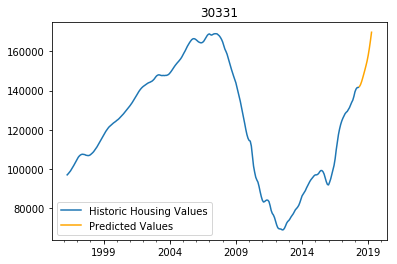

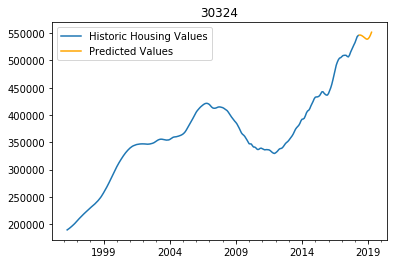

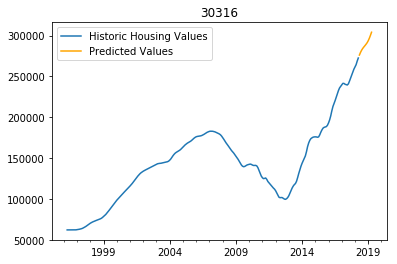

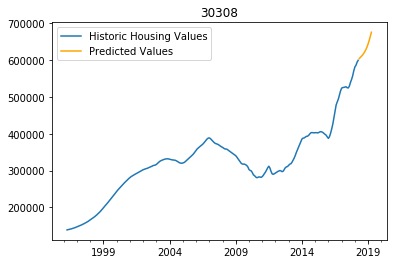

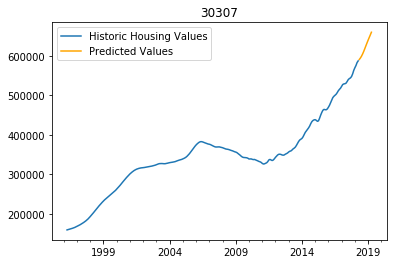

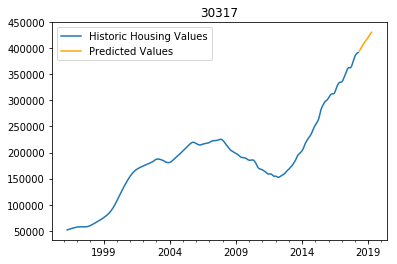

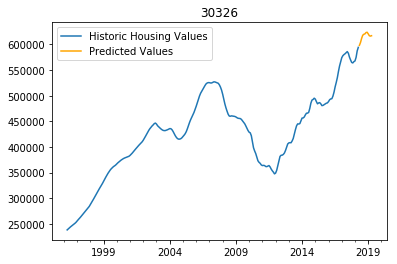

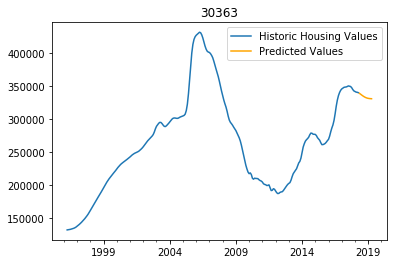

In [48]:
for forecast, zipcode, data in zip(zipcode_dfs_predict, predicted_zipcodes, zipcode_data):
    data.plot(label='Historic Housing Values')
    forecast['Values'][forecast.index.date > date(2018,4,1)].plot(color='orange', label='Predicted Values')
    plt.title(zipcode)
    plt.legend()
    plt.show()

In [24]:
results_dict = {"Zipcode": [], "Starting Value": [], "Next Month Gains": [], "6 Months Gains": [], "1 Year Gains": []}
for df, zipcode in zip(zipcode_dfs_predict, predicted_zipcodes):
    results_dict['Zipcode'].append(zipcode)
    results_dict['Starting Value'].append(df['Values']['2018-04-01'])
    next_month = df['Values']['2018-05-01'] - df['Values']['2018-04-01']
    results_dict['Next Month Gains'].append(next_month)
    six_month = df['Values']['2018-10-01'] - df['Values']['2018-04-01']
    results_dict['6 Months Gains'].append(six_month)
    next_year = df['Values']['2019-04-01'] - df['Values']['2018-04-01']
    results_dict['1 Year Gains'].append(next_year)
results_df = pd.DataFrame(results_dict)
results_df['Next Month Gain Percentage'] = results_df['Next Month Gains']/results_df['Starting Value'] * 100
results_df['6 Months Gain Percentage'] = results_df['6 Months Gains']/results_df['Starting Value'] * 100
results_df['1 Year Gain Percentage'] = results_df['1 Year Gains']/results_df['Starting Value'] * 100

In [25]:
results_df

,Zipcode,Starting Value,Next Month Gains,6 Months Gains,1 Year Gains,Next Month Gain Percentage,6 Months Gain Percentage,1 Year Gain Percentage
0,30331,141600.0,396.764463,8947.312594,28055.698550,0.280201,6.318724,19.813346
1,30324,545700.0,843.181709,-4563.183048,5965.400947,0.154514,-0.836207,1.093165
2,30316,272500.0,3606.876508,15060.527478,31492.949273,1.323624,5.526799,11.557046
3,30308,599300.0,4682.472680,23428.434818,76196.364350,0.781324,3.909300,12.714227
4,30307,587100.0,3612.819726,30957.503441,72630.914229,0.615367,5.272952,12.371132
5,30317,391600.0,3141.415966,20498.851961,38814.472521,0.802200,5.234640,9.911765
6,30326,594400.0,3901.355773,26309.768896,22702.521179,0.656352,4.426273,3.819401
7,30363,340300.0,-969.760626,-6811.555075,-9200.041250,-0.284972,-2.001632,-2.703509


Our Five Best Zipcodes are: 30331, 30316, 30308, 30307, and 30317

# Future Work

In the future, because I went with the linear regression approach, I want to try adding additional features to the model based on outside factors that affect the housing market. Looking at factors like interest rates, GDP, CPI,and the amount of people moving to Atlanta yearly or monthly.

I also would want to possibly run a seasonal ARIMA just to experiment to see if the model works better, even if the seasonal component is smaller.